<a href="https://colab.research.google.com/github/klaudiakor/Studia/blob/IO/SOMheart_git.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [Statlog (Heart) Data Set](https://archive.ics.uci.edu/ml/datasets/statlog+(heart))


W zbiorze danych możemy znaleźć następujące informacje, które posłużą nam do przewidzenia czy u osoby o danym zestawie atrybutów występuje choroba serca czy nie.

Atrybuty:
------------------------
1. wiek
2. płeć
3. typ bólu w klatce piersiowej (4 wartości)
4. ciśnienie krwi w spoczynku
5. cholesterol w surowicy krwi [mg/dl]
6. cukier w krwi naczczo > 120 [mg/dl]
7. wynik elektrokardiograficzny w spoczynku (wartości 0,1,2)
8. osiągnięta maksymalna częstość akcji serca
9. dławica piersiowa indukowana wysiłkiem
10. oldpeak = obniżenie odcinka ST wywołane wysiłkiem fizycznym w stosunku do spoczynku  
11. szczytowe nachylenie odcinka ST w czasie wysiłku fizycznego 
12. liczba głównych naczyń (0-3) pokolorowanych przez fluoroskopię  
13. hemoglobina(poziom) thal: 3 = normalny; 6 = utrwalony ubytek; 7 = odwracalny ubytek

Dysponujemy:
-------------
- 270 rekordami
- 2 klasy danych (choroba lub jej brak)
- 13 atrybutów
- z klasy brak choroby mamy 150 przypadków, a klasy choroba 120  


# SOM - Self organizing map
--------

In [ ]:
!pip install minisom

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from pandas import get_dummies
from matplotlib.lines import Line2D
from pylab import bone, pcolor, colorbar, plot, show
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler


## Przygotowanie danych

Poniżej odczytuje dane i koduje w inny sposób dane kategoryczne. 

Jeśli chodzi o kolumnę wiek, dzielimy ją na 3 klasy:
* 21-40 lat -> 0
* 41-60 lat -> 1
* 61-90 lat -> 2

Następnie wykorzystuje funkcję get_dummies, która rozdziela podaną kolumnę na tyle kolumn ile jest w niej typów i dane w każdej zapisuje binarnie, albo jest ten typ albo go nie ma. 

Dziele dane na 2 zbiory testowy i treningowy, przy czym X oznacza zmienne niezależne tzw. features, a y to już zmienne zależne, czyli poprawna odpowiedź.
Ponieważ SOM jest samoorganizującą się mapą, bez nadzoru, chcę mu dać jak najwięcej danych do trenowania, ponieważ nie wykorzystuje zbioru walidacyjnego przy nauce. Przeprowadzając kilka testów uznałam, że najlepiej będzie ustalić rozmiar zbioru testowego na 30% a treningowego na 70%. 

In [3]:
#import dataset
dataset=pd.read_csv("heart.data", delimiter=' ')
heart_data = dataset

y = dataset.iloc [:, -1].values #dependent variables (output of process)
dataset = dataset.drop("absence_(1)_or_presence_(2)_heart_disease",axis=1) #TODO: different name in data

bins = [20,40,60,90]
labels = [0,1,2]
dataset['age'] = pd.cut(dataset.age,bins,labels=labels)
dataset = get_dummies(data=dataset, columns=["sex","age", "chest_pain_type", "fasting_blood_sugar_>_120_mg/dl", "resting_electrocardiographic_results", "exercise_induced_angina", "the_slope_of_the_peak_exercise_ST_segment", "number_of_major_vessels", "thal"])

X = dataset.values #independent variables (features)
dataset.head()



,resting_blood_pressure,serum_cholestoral_in_mg/dl,maximum_heart_rate_achieved,oldpeak,sex_0.0,sex_1.0,age_0,age_1,age_2,chest_pain_type_1.0,...,the_slope_of_the_peak_exercise_ST_segment_1.0,the_slope_of_the_peak_exercise_ST_segment_2.0,the_slope_of_the_peak_exercise_ST_segment_3.0,number_of_major_vessels_0.0,number_of_major_vessels_1.0,number_of_major_vessels_2.0,number_of_major_vessels_3.0,thal_3.0,thal_6.0,thal_7.0
0,130.0,322.0,109.0,2.4,0,1,0,0,1,0,...,0,1,0,0,0,0,1,1,0,0
1,115.0,564.0,160.0,1.6,1,0,0,0,1,0,...,0,1,0,1,0,0,0,0,0,1
2,124.0,261.0,141.0,0.3,0,1,0,1,0,0,...,1,0,0,1,0,0,0,0,0,1
3,128.0,263.0,105.0,0.2,0,1,0,0,1,0,...,0,1,0,0,1,0,0,0,0,1
4,120.0,269.0,121.0,0.2,1,0,0,0,1,0,...,1,0,0,0,1,0,0,1,0,0


Tutaj widzimy już nasze dane po zabiegach związanych z pozbyciem się danych kategorycznych.

In [4]:
# split the dataset into training (70%) and testing (30%) sets
test_size = 0.3
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=test_size,random_state=0) 

#### Skalowanie
Chcę aby wszystkie dane były w tej samej skali, więc je skaluje tak aby mieściły się w zakresie (0, 1).
Jest to ważne, jeśli chce aby SOM traktował wszystkie cechy jako równie ważne. 

Jest możliwe jeszcze inne podejście, jeśli niektóre z cech są ważniejsze dla trendu możemy je przeskalować tak aby znajdowały się w większym zakresie. Spróbuję tego podejścia w dalszej części.


In [5]:
# feature scaling
def scale_in_range(data, range):
    return MinMaxScaler(feature_range=(0,range)).fit_transform(data)

X_train = scale_in_range(X_train, 1)
X_test = scale_in_range(X_test, 1)


## Budowanie i trenowanie modelu

Używam biblioteki [MiniSom](https://github.com/JustGlowing/minisom)

In [6]:
from minisom import MiniSom

Do oceny SOM używa się różnych metryk, każda z nich mierzy co innego na temat SOM. W bibliotece MiniSom są zaimplementowane 2 metryki:
* Quantization Error - jest to średnia odległość punktu danych do najbliższego węzła sieci. Może mierzyć, jak dobrze odwzorowanie pasuje do rozkładu danych. Nie mierzy ona czy siatka pasuje do topologii lub kształtu danych. Daje dobre pojęcie o tym, jak dobrze mapa pasuje do danych. Jest to dobra metryka, jeśli próbujemy określić, czy mapa ma węzły w pobliżu gęstych skupisk. (Co ważne: dodanie większej ilości węzłów do siatki spowoduje obniżenie tego błędu, jednak może to zacząć nadmiernie dopasowywać dane)

* Topographic Error - ma na celu uchwycenie informacji, których Quantization error nie może. Mierzy on jak dobrze kształt danych jest zachowany w przestrzeni wyjściowej. (Może dać ogólne pojęcie o tym, jak dobrze mapa zachowuje topologię danych)


W poniższej komórce poszukuje odpowiedniej ilości iteracji, aby zminimalizować te błędy.
Wybieram początkową siatkę jako 9x9 ponieważ według zaleceń dotyczacych tworzenia map SOM ilość neuronów siatki powinna wynosić $5\sqrt{n}$ gdzie n jest ilością danych. W tym zestawie danych mamy 270 wierszy, zatem: $5\sqrt{270}\approx 82$. Chcę aby siatka była kwadratowa dlatego dobieram ilość wierszy i kolumn równą $\sqrt{82}\approx 9$

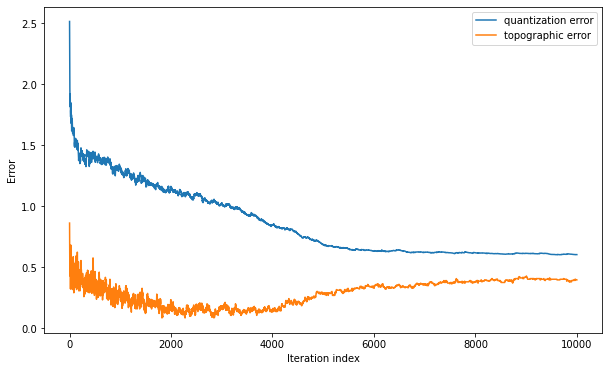

In [7]:
som_grid_rows = 9
som_grid_columns = 9
sigma = 2
learning_rate = 0.5
neighborhood_function = "triangle"
topology = 'rectangular'
activation_distance = 'euclidean'
som9x9=MiniSom(x=som_grid_rows, y=som_grid_columns, input_len=X.shape[1], sigma = sigma, learning_rate= learning_rate, neighborhood_function=neighborhood_function, topology=topology,activation_distance=activation_distance)

max_iter = 10000
q_error = []
t_error = []

data = X_train
for i in range(max_iter):
    rand_i = np.random.randint(len(data))
    som9x9.update(data[rand_i], som9x9.winner(data[rand_i]), i, max_iter)
    q_error.append(som9x9.quantization_error(data))
    t_error.append(som9x9.topographic_error(data))

plt.figure(figsize=(10, 6))
plt.plot(np.arange(max_iter), q_error, label='quantization error')
plt.plot(np.arange(max_iter), t_error, label='topographic error')
plt.ylabel('Error')
plt.xlabel('Iteration index')
plt.legend()
plt.show()

Na wykresie widzę, że najbardziej optymalnie będzie przyjąć ilość iteracji jako 5000.

#### Inicjalizacja modelu SOM
* x,y - wymiary mapy
* input_len - ilość kolumn
* sigma - promień sąsiedztwa (domyślnie: 1)
* learning rate - jak bardzo waga jest aktualizowana podczas każdej iteracji (domyślnie: 0.5), w funkcji MiniSom podajemy tylko początkową wartość uczenia ponieważ jest ona zmniejszana w każdej iteracj wg. wzoru learning_rate(t) = learning_rate / (1 + t/T) (gdzie T = liczba iteracji/2, a t to numer iteracji)
* neighborhood_function - funkcja sąsiedztwa, możliwe wartości: 'gaussian', 'mexican_hat', 'bubble', 'triangle' (domyślnie: 'gaussian')
* topology - topologia mapy, możliwe wartości: 'rectangular', 'hexagonal' (domyślnie: 'rectangular'), przy użyciu mapy heksagonalnej zwiększamy ilość sąsiadów jednego neuronu
* activation_distance - definiuje matryke którą mieżymy odległości między wagą neuronu a daną wejściową,
    możliwe wartości: 'euclidean', 'cosine', 'manhattan', 'chebyshev' (domyślnie: 'euclidean')


In [8]:
# set hyperparameters

som_grid_rows = int(np.sqrt(5*np.sqrt(dataset.shape[0])))
som_grid_columns = som_grid_rows
iterations = 5000

#default
sigma = 1
learning_rate = 0.5
neighborhood_function = "gaussian"
topology = 'rectangular'
activation_distance = 'euclidean'

 Sprawdzam model dla domyślnych wartości oraz wielkości siatki 9x9


Inicjalizuje model z podanymi parametrami oraz inicjalizuje wagi losowymi wartościami.

In [9]:
som=MiniSom(x=som_grid_rows, y=som_grid_columns, input_len=X.shape[1], sigma = sigma, learning_rate= learning_rate, neighborhood_function=neighborhood_function, topology=topology,activation_distance=activation_distance)
som.random_weights_init(X_train)

#### Trenowanie modelu
Aby wytrenować model używam funkcji train która przyjmuje dane, ilość iteracji, można również podać czy próbki mają być wybierane w losowej kolejności, jeśli nie ustalimy tego parametru są pobierane w kolejności, parametr verbose służy do wyświetlenia statusu trenowania w każdej iteracji

Sprawdzam jak sposób wyboru próbek wpłynie na quantization i topographic error.

 [ 5000 / 5000 ] 100% - 0:00:00 left 
 quantization error: 0.7616015207236785
 topographic_error:  0.21693121693121692


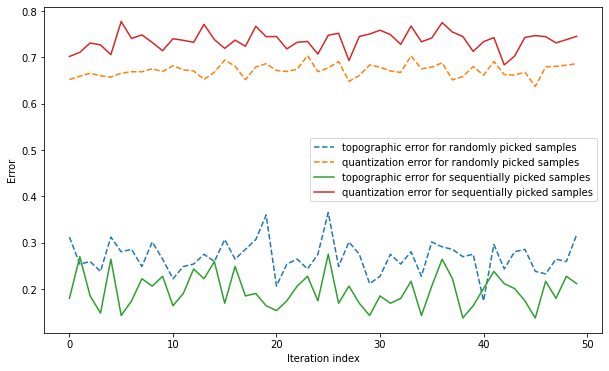

In [10]:
som.train(data=X_train, num_iteration=iterations, random_order= False, verbose=True)
print(" topographic_error: ", som.topographic_error(X_train))
Et_rand = []
Eq_rand = []
Et = []
Eq= []
max_iter = 50
for i in range(max_iter):
    som.train(data=X_train, num_iteration=iterations, random_order= True, verbose=False)
    Et_rand.append(som.topographic_error(X_train))
    Eq_rand.append(som.quantization_error(X_train))
    som.train(data=X_train, num_iteration=iterations, random_order= False, verbose=False)
    Et.append(som.topographic_error(X_train))
    Eq.append(som.quantization_error(X_train))

plt.figure(figsize=(10, 6))
plt.plot(np.arange(max_iter), Et_rand, '--', label='topographic error for randomly picked samples')
plt.plot(np.arange(max_iter), Eq_rand,'--', label='quantization error for randomly picked samples')
plt.plot(np.arange(max_iter), Et, label='topographic error for sequentially picked samples')
plt.plot(np.arange(max_iter), Eq, label='quantization error for sequentially picked samples')
plt.ylabel('Error')
plt.xlabel('Iteration index')
plt.legend()
plt.show()

Nie widać znacznej poprawy przy zmianie sposobu wybierania próbek. Dla losowego wybierania quantization error jest nieco mniejszy, jednak topographic error jest nieco większy niż analogiczny dla wybierania próbek sekwencyjnie. Dlatego zostane przy wybieraniu próbek sekwencyjnie.

Trenuje model na zbiorze treningowym X_train, z zadaną ilością iteracji.

In [11]:
#training the model

som.train(data=X_train, num_iteration=iterations, random_order= False, verbose=True)
print(" topographic_error: ", som.topographic_error(X_train))


 [ 5000 / 5000 ] 100% - 0:00:00 left 
 quantization error: 0.7156727908721803
 topographic_error:  0.13756613756613756


## Wizualizacja wyników

In [12]:
def draw_distance_plot(som):
    bone()
    pcolor(som.distance_map().T)
    colorbar()
   
def draw_classes(som, X_train, y_train):
    markers = ['NaN', 's', 'o']
    colors = ['NaN', 'g', 'r']
    for i,x in enumerate(X_train):
        w = som.winner(x)
        plot(w[0] + 0.5, w[1] + 0.5, markers[y_train[i]], markeredgecolor=colors[y_train[i]], markerfacecolor='None', markersize=10, markeredgewidth=2)

def draw_legend_for_Umatrix(bbox_to_anchor):
    absence_of_disease =Line2D([0], [0], marker='o',markerfacecolor='None', color='red', label='presence of disease', markersize=10, linestyle='None', markeredgewidth=2)
    presence_of_disease =Line2D([0], [0], marker='s',markerfacecolor='None', color='green', label='absence of disease', markersize=10, linestyle='None', markeredgewidth=2)
    plt.legend(handles=[absence_of_disease, presence_of_disease], loc='upper center', bbox_to_anchor=bbox_to_anchor,
            fancybox=True, shadow=True, ncol=2, fontsize=12)

#### U-Matrix

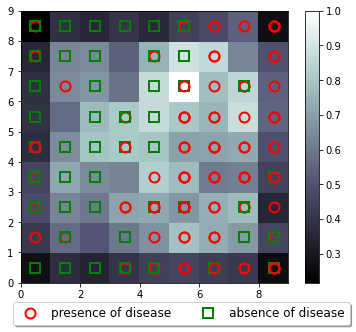

In [13]:
plt.figure(figsize=(6,5))
draw_distance_plot(som)
draw_classes(som, X_train, y_train)
draw_legend_for_Umatrix((0.6, -0.05))

Ten wykres reprezentuje siatke SOM, każdy "kwadracik" odpowiada jednemu neuronowi z siatki.

Dla każdego wzorca w zbiorze danych odpowiednie neurony wygrywające zostały oznaczone. Brak choroby serca reprezentowany jest przez zielony kwadrat, natomiast choroba jako czerwnony okrąg.

Jako tło używam średniej mapy odległości wag (distance map). Jasny kolor odpowiada dużej odległości między neuronami, ciemny oznacza, że neurony są blisko siebie. Ciemne obszary można traktować jako klastry, a jasne jako separatory klastrów.

Na tym wykresie właściwie nie widzimy rozdzielenia klastrów, na wielu neuronach obie klasy nachodzą się na siebie. 

#### Rozmieszczenie próbek

In [14]:
# 1 - absence of disease - green square
# 2 - presence of disease - red circle

def draw_clusters(som, X_train):

    for i,x in enumerate(X_train):
        w = som.winner(x)
        if y_train[i] == 1:
            plt.scatter(w[0] + 0.5, w[1] + 0.5, color='green', marker='s', alpha = 0.5, s=1000)  
        if y_train[i] == 2:
            plt.scatter(w[0] + 0.5, w[1] + 0.5, color='red', marker='o', alpha = 0.5, s=1000)
    
def draw_winner(winner_coords, color, marker, offset):
    plt.scatter(winner_coords[0] + 0.5 + random.uniform(-offset, offset), winner_coords[1] + 0.5 + random.uniform(-offset, offset), marker=marker, color=color, s=50)

def draw_samples(som, X_test, y_test, marker, color1, color2, offset):
    for i,x in enumerate(X_test):
        w = som.winner(x)
        if y_test[i] == 1:
            draw_winner(w, color1, marker, offset)
        if y_test[i] == 2:
            draw_winner(w, color2, marker, offset)

def draw_legend_for_sample_distribution(bbox_to_anchor):
    #bbox_to_anchor=(-0.1, -0.05) - for centre
    red_o =Line2D([0], [0], marker='o', color='red', label='presence of disease', markersize=10, linestyle='None', markeredgewidth=2)
    green_s =Line2D([0], [0], marker='s', color='green', label='absence of disease ', markersize=10, linestyle='None', markeredgewidth=2)
    red_x =Line2D([0], [0], marker='x', color='pink', label='presence of disease - sample', markersize=10, linestyle='None', markeredgewidth=2)
    green_x =Line2D([0], [0], marker='x', color='lightgreen', label='absence of disease - sample', markersize=10, linestyle='None', markeredgewidth=2)
    plt.legend(handles=[green_s, red_o, red_x, green_x], loc='upper center', bbox_to_anchor=bbox_to_anchor,
            fancybox=True, shadow=False, ncol=2, fontsize=12)

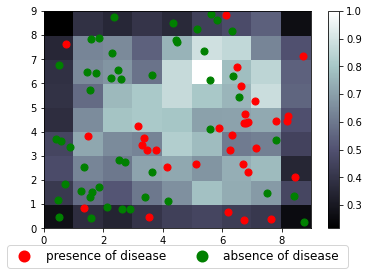

In [15]:
#sample distribution

draw_distance_plot(som)
draw_samples(som, X_test, y_test, marker='o', color1='green', color2='red', offset=0.4)

red =Line2D([0], [0], marker='o', color='red', label='presence of disease', markersize=10, linestyle='None', markeredgewidth=2)
green =Line2D([0], [0], marker='o', color='green', label='absence of disease ', markersize=10, linestyle='None', markeredgewidth=2)
plt.legend(handles=[red, green], loc='upper center', bbox_to_anchor=(0.5, -0.05),
            fancybox=True, shadow=False, ncol=2, fontsize=12)

Na tym wykresnie naniosłam na mapę odległości próbki z dodanym losowym ofsetem, aby uniknąć nakladania się na siebie punktów w tej samiej komórce. 

Widzimy ze klasy mieszają się ze sobą, siatka nie zorganizowała się zbyt dobrze.

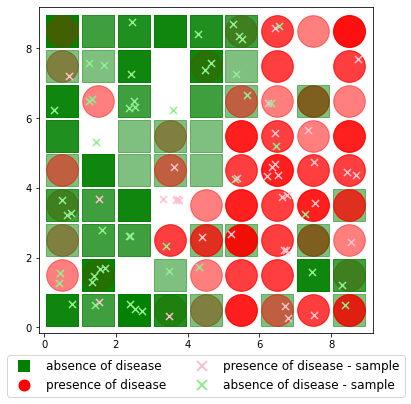

In [16]:
plt.figure(figsize=(6,6))
draw_clusters(som, X_train)
draw_samples(som, X_test, y_test, marker='x', color1='lightgreen', color2='pink', offset=0.3)
draw_legend_for_sample_distribution((0.5, -0.05))

Na tym wykresie wyświetlam wygrywające neurony z zbioru treningowego jako duże zielone kwadraty, które reprezentują brak choroby oraz duże czerowne kółka, które reprezentują obecność choroby. Te elementy ustawiam tak aby były w pewnym stopniu przezroczyste, co pozwala zobaczyć ich zagęszczenie na danym neuronie oraz czy dwie różne klasy się na siebie nakładają.

Nanosze na nie wygrywające neurony ze zbioru testowego z randomowym ofsetem aby uniknąć nakładania się ich na siebie.

Tutaj można łatwo zobaczyć jak dobrze sieć klasyfikuje dane testowe.
Zielone znaczniki 'x' powinny trafiać w zielone kwadraty, a różowe w czerwone kółka, jeśli jest na odwrót to znaczy, że próbka została źle sklasyfikowana.



#### Częstotliwość aktywacji neuronów

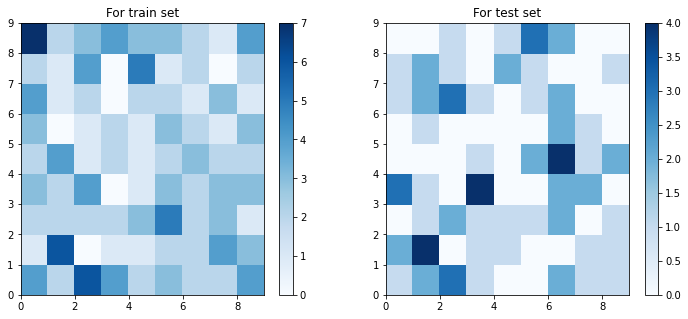

In [17]:
plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
plt.title("For train set")
frequencies = som.activation_response(X_train)
plt.pcolor(frequencies.T, cmap='Blues') 
plt.colorbar()

plt.subplot(1,2,2)
plt.title("For test set")
frequencies = som.activation_response(X_test)
plt.pcolor(frequencies.T, cmap='Blues') 
plt.colorbar()
plt.show()

Na tym wykresie widzimy które neurony są częściej aktywowane.

### Wyniki

Korzystając z gotowej implementacji metody classify (zaczerpniętej ze strony https://www.kaggle.com/code/helvecioneto/som-examples) tworze classification_report, w którym zostaje obliczona precyzja dla sieci SOM.

In [18]:

def classify(som, data, winmap):
    
    default_class = np.sum(list(winmap.values())).most_common()[0][0]

    result = []
    for d in data:
        win_position = som.winner(d)
        if win_position in winmap:
            result.append(winmap[win_position].most_common()[0][0])
        else:
            result.append(default_class)
    return result

In [19]:

class_assignments = som.labels_map(X_train, y_train)
print(classification_report(y_test, classify(som, X_test, class_assignments), target_names=["absence of disease", "presence of disease"]))


                     precision    recall  f1-score   support

 absence of disease       0.78      0.75      0.77        48
presence of disease       0.66      0.70      0.68        33

           accuracy                           0.73        81
          macro avg       0.72      0.72      0.72        81
       weighted avg       0.73      0.73      0.73        81



Wyświetlam raport z klasyfikacji, który mierzy jakość przewidywań sieci.
* **Precision** - dla klasy oznaczającej brak choroby jest większa.
* **Recall** - W tym przypadku również SOM lepiej radzi sobie z "brakiem choroby"


## Eksperymenty

Postaram się zmienić parametry sieci aby dawała lepsze wyniki.

In [20]:
# set hyperparameters
som_grid_rows = int(np.sqrt(5*np.sqrt(dataset.shape[0])))
som_grid_columns = som_grid_rows
iterations = 5000
sigma = 2
learning_rate = 0.5
neighborhood_function = "bubble"
topology = 'rectangular'
activation_distance = 'euclidean'

Dla funkcji sąsiedztwa bubble

In [21]:

som=MiniSom(x=som_grid_rows, y=som_grid_columns, input_len=X.shape[1], sigma = sigma, learning_rate= learning_rate, neighborhood_function=neighborhood_function, topology=topology,activation_distance=activation_distance)
som.random_weights_init(X_train)

som.train(data=X_train, num_iteration=iterations, random_order= False, verbose=True)
print(" topographic_error: ", som.topographic_error(X_train))

Et_bubble = som.topographic_error(X_train)
Eq_bubble = som.quantization_error(X_train)


 [ 5000 / 5000 ] 100% - 0:00:00 left 
 quantization error: 0.7368520306649825
 topographic_error:  0.4126984126984127


Zauważam, że dla sigmy większej od 2 błąd kwantyzacji rośnie.
Kiedy zmieniam learning rate na niższy niż 0.5 to rosną błędy, a accuracy spada.
Za to kiedy go zwiększam rośnie accurancy, ale również rosną błędy. <br>
Dla learning rate = 1: <br>
Eq jest w okolicach 0.7<br>
Et jest w okolicach 0.5 <br>
Accurancy wacha się między 0.63 - 0.70 <br>
Pozostanę przy learning rate równym 0.5 aby nie zwiększać błędów.


In [22]:

class_assignments = som.labels_map(X_train, y_train)
print(classification_report(y_test, classify(som, X_test, class_assignments), target_names=["absence of disease", "presence of disease"]))

report_bubble = classification_report(y_test, classify(som, X_test, class_assignments), target_names=["absence of disease", "presence of disease"], output_dict=True)


                     precision    recall  f1-score   support

 absence of disease       0.74      0.71      0.72        48
presence of disease       0.60      0.64      0.62        33

           accuracy                           0.68        81
          macro avg       0.67      0.67      0.67        81
       weighted avg       0.68      0.68      0.68        81



In [23]:
som_bubble = som

In [24]:
Et = [] # topographic error
Eq = [] # quantization error
Acc = [] # accuracy
lr=[]

Dla funkcji sąsiedztwa gaussian

In [25]:
# set hyperparameters
som_grid_rows = int(np.sqrt(5*np.sqrt(dataset.shape[0])))
som_grid_columns = som_grid_rows
iterations = 5000
sigma = 1
# learning_rate = 3
neighborhood_function = "gaussian"
topology = 'rectangular'
activation_distance = 'euclidean'

In [26]:
for i in np.arange (0.1, 4, 0.1):
    learning_rate = i
    lr.append(i)
    som=MiniSom(x=som_grid_rows, y=som_grid_columns, input_len=X.shape[1], sigma = sigma, learning_rate= learning_rate, neighborhood_function=neighborhood_function, topology=topology,activation_distance=activation_distance)
    som.random_weights_init(X_train)

    som.train(data=X_train, num_iteration=iterations, random_order= False, verbose=False)

    Et.append(som.topographic_error(X_train))
    Eq.append(som.quantization_error(X_train))

    class_assignments = som.labels_map(X_train, y_train)
    report = classification_report(y_test, classify(som, X_test, class_assignments), target_names=["absence of disease", "presence of disease"], output_dict=True)
    Acc.append(report['accuracy'])

Kiedy zwiększam stopniowo wartość sigmy od 1, błąd kwantyzaci rośnie (z każdym kolejnym krokiem o mniejwięcej 0.1), za to topograficzny maleje (dla sigma = 1 => Et = 0.07, a dla sigma = 2 => Et=0.005, dla kolejnych sigm już się utrzymuje), accuracy delikatnie maleje. Najbardziej zmienia się błąd kwantyzacji i do tego rośnie dlatego ustawiam sigme na 1.


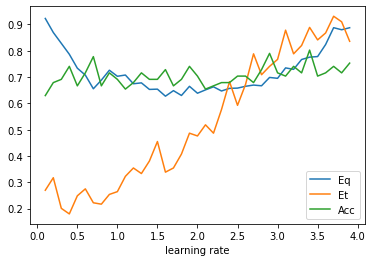

In [27]:
plt.plot( lr, Eq,label='Eq')
plt.plot(lr, Et, label='Et')
plt.plot( lr,Acc, label='Acc')
plt.xlabel("learning rate")
plt.legend()

Jak widać na wykresie wzrost learning rate najbardziej wpływa na błąd topograficzny. Myślę, że wybór 1 jako learning rate będzie najlepszy, bo błąd kwantyzacji już troszkę spadnie a topograficzny jeszcze nie zaczął bardzo rosnąć.

In [28]:
som_grid_rows = int(np.sqrt(5*np.sqrt(dataset.shape[0])))
som_grid_columns = som_grid_rows
iterations = 5000
sigma = 1
learning_rate = 1
neighborhood_function = "gaussian"
topology = 'rectangular'
activation_distance = 'euclidean'

In [29]:
som=MiniSom(x=som_grid_rows, y=som_grid_columns, input_len=X.shape[1], sigma = sigma, learning_rate= learning_rate, neighborhood_function=neighborhood_function, topology=topology,activation_distance=activation_distance)
som.random_weights_init(X_train)

som.train(data=X_train, num_iteration=iterations, random_order= False, verbose=False)

Et_gaussian = som.topographic_error(X_train)
Eq_gaussian = som.quantization_error(X_train)

In [30]:
report_gaussian = classification_report(y_test, classify(som, X_test, class_assignments), target_names=["absence of disease", "presence of disease"], output_dict=True)

In [31]:
som_gaussian = som

In [32]:
Et = [] # topographic error
Eq = [] # quantization error
Acc = [] # accuracy
lr=[]

Dla funkcji triangle

In [33]:
# set hyperparameters
som_grid_rows = int(np.sqrt(5*np.sqrt(dataset.shape[0])))
som_grid_columns = som_grid_rows
iterations = 5000
# sigma = 1
learning_rate = 1
neighborhood_function = "triangle"
topology = 'rectangular'
activation_distance = 'euclidean'

In [34]:
for i in range(1, 5):
    sigma = i
    lr.append(i)
    som=MiniSom(x=som_grid_rows, y=som_grid_columns, input_len=X.shape[1], sigma = sigma, learning_rate= learning_rate, neighborhood_function=neighborhood_function, topology=topology,activation_distance=activation_distance)
    som.random_weights_init(X_train)

    som.train(data=X_train, num_iteration=iterations, random_order= False, verbose=False)

    Et.append(som.topographic_error(X_train))
    Eq.append(som.quantization_error(X_train))

    class_assignments = som.labels_map(X_train, y_train)
    report = classification_report(y_test, classify(som, X_test, class_assignments), target_names=["absence of disease", "presence of disease"], output_dict=True)
    Acc.append(report['accuracy'])

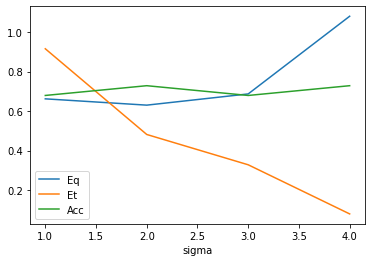

In [35]:
plt.plot( lr, Eq,label='Eq')
plt.plot(lr, Et, label='Et')
plt.plot( lr,Acc, label='Acc')
plt.xlabel("sigma")
plt.legend()

Ustawię sigme na 2, kiedy błąd topograficzny spadnie a błąd kwantyzacji jeszcze nie wzrośnie bardzo.

In [36]:
Et = [] # topographic error
Eq = [] # quantization error
Acc = [] # accuracy
lr=[]

In [37]:
# set hyperparameters
som_grid_rows = int(np.sqrt(5*np.sqrt(dataset.shape[0])))
som_grid_columns = som_grid_rows
iterations = 5000
sigma =2
# learning_rate = 1
neighborhood_function = "triangle"
topology = 'rectangular'
activation_distance = 'euclidean'

In [ ]:
for i in np.arange (0.1, 4, 0.1):
# for i in range(1, 5):
    learning_rate = i
    lr.append(i)
    som=MiniSom(x=som_grid_rows, y=som_grid_columns, input_len=X.shape[1], sigma = sigma, learning_rate= learning_rate, neighborhood_function=neighborhood_function, topology=topology,activation_distance=activation_distance)
    som.random_weights_init(X_train)

    som.train(data=X_train, num_iteration=iterations, random_order= False, verbose=False)

    Et.append(som.topographic_error(X_train))
    Eq.append(som.quantization_error(X_train))

    class_assignments = som.labels_map(X_train, y_train)
    report = classification_report(y_test, classify(som, X_test, class_assignments), target_names=["absence of disease", "presence of disease"], output_dict=True)
    Acc.append(report['accuracy'])

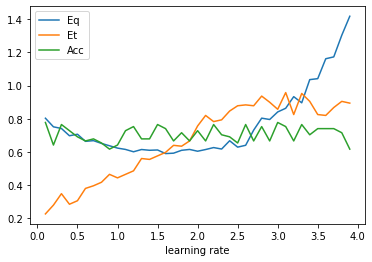

In [39]:
plt.plot( lr, Eq,label='Eq')
plt.plot(lr, Et, label='Et')
plt.plot( lr,Acc, label='Acc')
plt.xlabel("learning rate")
plt.legend()

Wybieram learning rate jako wartość pomiędzy 0.5 i 1, bo tam Eq spadnie troochę, a Et nie zaczyna jeszcze drastycznie rosnąć.
Niech learning rate = 0.7.

In [40]:
# set hyperparameters
som_grid_rows = int(np.sqrt(5*np.sqrt(dataset.shape[0])))
som_grid_columns = som_grid_rows
iterations = 5000
sigma =2
learning_rate = 0.7
neighborhood_function = "triangle"
topology = 'rectangular'
activation_distance = 'euclidean'

In [41]:
som=MiniSom(x=som_grid_rows, y=som_grid_columns, input_len=X.shape[1], sigma = sigma, learning_rate= learning_rate, neighborhood_function=neighborhood_function, topology=topology,activation_distance=activation_distance)
som.random_weights_init(X_train)

som.train(data=X_train, num_iteration=iterations, random_order= False, verbose=True)
print(" topographic_error: ", som.topographic_error(X_train))

Et_triangle = som.topographic_error(X_train)
Eq_triangle = som.quantization_error(X_train)

 [ 5000 / 5000 ] 100% - 0:00:00 left 
 quantization error: 0.6295862869665969
 topographic_error:  0.3544973544973545


In [42]:

class_assignments = som.labels_map(X_train, y_train)
print(classification_report(y_test, classify(som, X_test, class_assignments), target_names=["absence of disease", "presence of disease"]))

report_triangle = classification_report(y_test, classify(som, X_test, class_assignments), target_names=["absence of disease", "presence of disease"], output_dict=True)


                     precision    recall  f1-score   support

 absence of disease       0.80      0.67      0.73        48
presence of disease       0.61      0.76      0.68        33

           accuracy                           0.70        81
          macro avg       0.70      0.71      0.70        81
       weighted avg       0.72      0.70      0.71        81



In [43]:
som_triangle=som

Dla funkcji mexican hat

In [44]:
Et = [] # topographic error
Eq = [] # quantization error
Acc = [] # accuracy
lr=[]

In [45]:
# set hyperparameters
som_grid_rows = int(np.sqrt(5*np.sqrt(dataset.shape[0])))
som_grid_columns = som_grid_rows
iterations = 5000
# sigma =2
learning_rate = 0.5
neighborhood_function = "mexican_hat"
topology = 'rectangular'
activation_distance = 'euclidean'

In [ ]:
for i in range(1, 9):
    sigma = i
    lr.append(i)
    som=MiniSom(x=som_grid_rows, y=som_grid_columns, input_len=X.shape[1], sigma = sigma, learning_rate= learning_rate, neighborhood_function=neighborhood_function, topology=topology,activation_distance=activation_distance)
    som.random_weights_init(X_train)

    som.train(data=X_train, num_iteration=iterations, random_order= False, verbose=False)

    Et.append(som.topographic_error(X_train))
    Eq.append(som.quantization_error(X_train))

    class_assignments = som.labels_map(X_train, y_train)
    report = classification_report(y_test, classify(som, X_test, class_assignments), target_names=["absence of disease", "presence of disease"], output_dict=True)
    Acc.append(report['accuracy'])

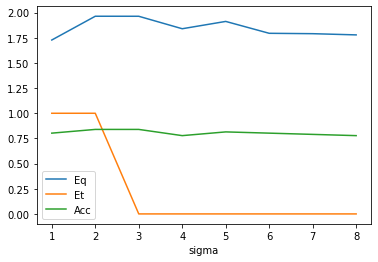

In [47]:
plt.plot( lr, Eq,label='Eq')
plt.plot(lr, Et, label='Et')
plt.plot( lr,Acc, label='Acc')
plt.xlabel("sigma")
plt.legend()

Sensownym wyborem sigmy dla tej funkcji będzie 1 patrząc na Eq, jednak dla większej sigmy Et drastycznie spada, dlatego dobiore sigme równą 7.

In [48]:
Et = [] # topographic error
Eq = [] # quantization error
Acc = [] # accuracy
lr=[]

In [49]:
# set hyperparameters
som_grid_rows = int(np.sqrt(5*np.sqrt(dataset.shape[0])))
som_grid_columns = som_grid_rows
iterations = 5000
sigma = 7
# learning_rate = 0.5
neighborhood_function = "mexican_hat"
topology = 'rectangular'
activation_distance = 'euclidean'

In [ ]:

for i in np.arange (0.1, 4, 0.2):
    learning_rate = i
    lr.append(i)
    som=MiniSom(x=som_grid_rows, y=som_grid_columns, input_len=X.shape[1], sigma = sigma, learning_rate= learning_rate, neighborhood_function=neighborhood_function, topology=topology,activation_distance=activation_distance)
    som.random_weights_init(X_train)

    som.train(data=X_train, num_iteration=iterations, random_order= False, verbose=False)

    Et.append(som.topographic_error(X_train))
    Eq.append(som.quantization_error(X_train))

    class_assignments = som.labels_map(X_train, y_train)
    report = classification_report(y_test, classify(som, X_test, class_assignments), target_names=["absence of disease", "presence of disease"], output_dict=True)
    Acc.append(report['accuracy'])

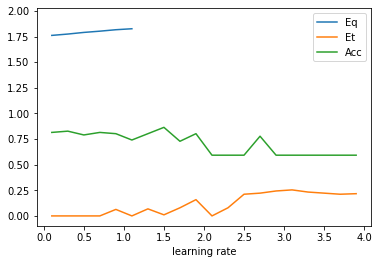

In [51]:
plt.plot( lr, Eq,label='Eq')
plt.plot(lr, Et, label='Et')
plt.plot( lr,Acc, label='Acc')
plt.xlabel("learning rate")
plt.legend()

Wybiore jak najmniejszy learning rate, niech będzie równy 0.1

In [52]:
# set hyperparameters
som_grid_rows = int(np.sqrt(5*np.sqrt(dataset.shape[0])))
som_grid_columns = som_grid_rows
iterations = 5000
sigma = 7
learning_rate = 0.1
neighborhood_function = "mexican_hat"
topology = 'rectangular'
activation_distance = 'euclidean'

In [53]:
som=MiniSom(x=som_grid_rows, y=som_grid_columns, input_len=X.shape[1], sigma = sigma, learning_rate= learning_rate, neighborhood_function=neighborhood_function, topology=topology,activation_distance=activation_distance)
som.random_weights_init(X_train)

som.train(data=X_train, num_iteration=iterations, random_order= False, verbose=True)
print(" topographic_error: ", som.topographic_error(X_train))

Et_mexican_hat = som.topographic_error(X_train)
Eq_mexican_hat = som.quantization_error(X_train)

 [ 5000 / 5000 ] 100% - 0:00:00 left 
 quantization error: 1.724803557466089
 topographic_error:  0.0


In [54]:

class_assignments = som.labels_map(X_train, y_train)
print(classification_report(y_test, classify(som, X_test, class_assignments), target_names=["absence of disease", "presence of disease"]))

report_mexican_hat = classification_report(y_test, classify(som, X_test, class_assignments), target_names=["absence of disease", "presence of disease"], output_dict=True)


                     precision    recall  f1-score   support

 absence of disease       0.92      0.75      0.83        48
presence of disease       0.71      0.91      0.80        33

           accuracy                           0.81        81
          macro avg       0.82      0.83      0.81        81
       weighted avg       0.84      0.81      0.82        81



In [55]:
som_mexican_hat=som

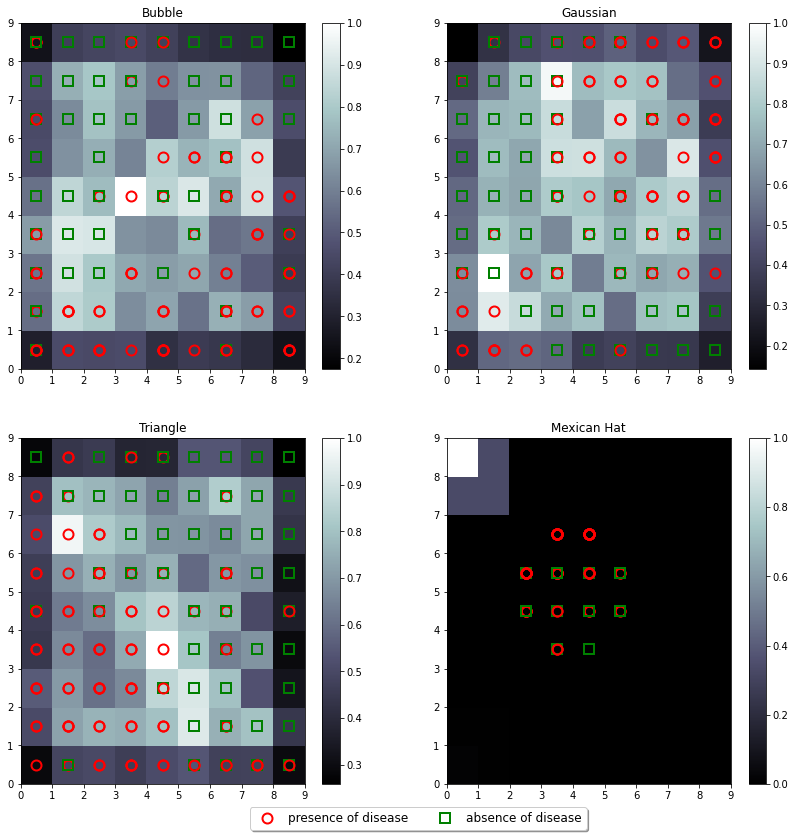

In [56]:
plt.figure(figsize=(14,14))

plt.subplot(2, 2, 1)
plt.title("Bubble")
draw_distance_plot(som_bubble)
draw_classes(som_bubble, X_train, y_train)

plt.subplot(2, 2, 2)
plt.title("Gaussian")
draw_distance_plot(som_gaussian)
draw_classes(som_gaussian, X_train, y_train)

plt.subplot(2, 2, 3)
plt.title("Triangle")
draw_distance_plot(som_triangle)
draw_classes(som_triangle, X_train, y_train)

plt.subplot(2, 2, 4)
plt.title("Mexican Hat")
draw_distance_plot(som_mexican_hat)
draw_classes(som_mexican_hat, X_train, y_train)

draw_legend_for_Umatrix((-0.1, -0.05))


Przeważnie dla funkcji sąsiedztwa triangle widzimy największe rozdzielenie klastrów, funkcje bubble i gaussian radzą sobie nieco gorzej, zato dla funkcji mexican hat dostajemy jeden wielki klaster, który wogóle nie rozróżnia naszych klas.

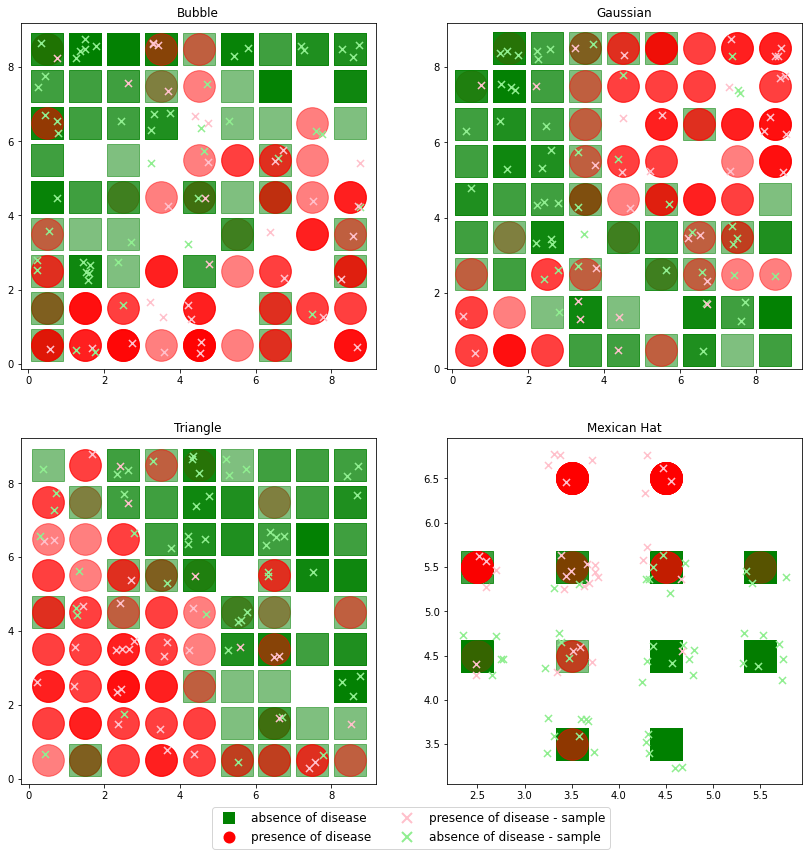

In [57]:
plt.figure(figsize=(14,14))
plt.subplot(2, 2, 1)
plt.title("Bubble")
draw_clusters(som_bubble, X_train)
draw_samples(som_bubble, X_test, y_test, marker='x', color1='lightgreen', color2='pink', offset=0.3)

plt.subplot(2, 2, 2)
plt.title("Gaussian")
draw_clusters(som_gaussian, X_train)
draw_samples(som_gaussian, X_test, y_test, marker='x', color1='lightgreen', color2='pink', offset=0.3)

plt.subplot(2, 2, 3)
plt.title("Triangle")
draw_clusters(som_triangle, X_train)
draw_samples(som_triangle, X_test, y_test, marker='x', color1='lightgreen', color2='pink', offset=0.3)

plt.subplot(2, 2, 4)
plt.title("Mexican Hat")
draw_clusters(som_mexican_hat, X_train)
draw_samples(som_mexican_hat, X_test, y_test, marker='x', color1='lightgreen', color2='pink', offset=0.3)

draw_legend_for_sample_distribution((-0.1, -0.05))

Tutaj widzimy jeszcze jak dane ze zbioru testowego układają się na naszej siatce. 

In [58]:
# accuracy porownanie i err
print("--- Bubble ---")
print("Accuracy: ", report_bubble['accuracy'])
print("Eq: ", Eq_bubble)
print("Et: ", Et_bubble)

print("--- Gaussian ---")
print("Accuracy: ", report_gaussian['accuracy'])
print("Eq: ", Eq_gaussian)
print("Et: ", Et_gaussian)

print("--- Triangle ---")
print("Accuracy: ", report_triangle['accuracy'])
print("Eq: ", Eq_triangle)
print("Et: ", Et_triangle)

print("--- Mexican hat ---")
print("Accuracy: ", report_mexican_hat['accuracy'])
print("Eq: ", Eq_mexican_hat)
print("Et: ", Et_mexican_hat)

--- Bubble ---
Accuracy:  0.6790123456790124
Eq:  0.7368520306649825
Et:  0.4126984126984127
--- Gaussian ---
Accuracy:  0.5432098765432098
Eq:  0.7010462721130835
Et:  0.2804232804232804
--- Triangle ---
Accuracy:  0.7037037037037037
Eq:  0.6295862869665969
Et:  0.3544973544973545
--- Mexican hat ---
Accuracy:  0.8148148148148148
Eq:  1.724803557466089
Et:  0.0


Z raportów równierz wynika, że funkcje sąsiedztwa triangle oraz bubble radzą sobie 
najlepiej. Funkcja triangle zwykle ma mniejsze błędy. Dlatego dalsze eksperymenty będe wykonywać przy jej użyciu. 



#### Rozmiar siatki
Możemy sprawdzić, czy napewno dobór siatki 9x9 jest optymalny dla tych danych

In [59]:
Et = [] # topographic error
Eq = [] # quantization error
Acc = [] # accuracy
iteration_num = []

In [60]:

iterations = 5000
sigma =2
learning_rate = 0.7
neighborhood_function = "triangle"
topology = 'rectangular'
activation_distance = 'euclidean'

In [ ]:
for i in range(3, 40):
    som_grid_rows = i
    som_grid_columns = i
    iteration_num.append(i)
    som=MiniSom(x=som_grid_rows, y=som_grid_columns, input_len=X.shape[1], sigma = sigma, learning_rate= learning_rate, neighborhood_function=neighborhood_function, topology=topology,activation_distance=activation_distance)
    som.random_weights_init(X_train)

    som.train(data=X_train, num_iteration=iterations, random_order= False, verbose=False)

    Et.append(som.topographic_error(X_train))
    Eq.append(som.quantization_error(X_train))

    class_assignments = som.labels_map(X_train, y_train)
    report = classification_report(y_test, classify(som, X_test, class_assignments), target_names=["absence of disease", "presence of disease"], output_dict=True)
    Acc.append(report['accuracy'])

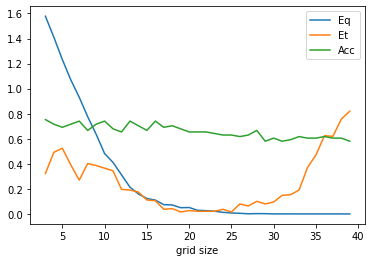

In [62]:
plt.plot( iteration_num, Eq,label='Eq')
plt.plot(iteration_num, Et, label='Et')
plt.plot( iteration_num,Acc, label='Acc')
plt.xlabel("grid size")
plt.legend()

To, że quantization error spada jest spowodowane tym, że mapa coraz lepiej pasuje do danych, ale nie o to nam chodzi przy tworzeniu modelu, ponieważ wtedy występuje przeuczenie.
Przy siatce o wymiarach większych niż 30x30 topographic error drastycznie rośnie, co znaczy że tracimy kształt danych.
Widać, że accuracy spada, dla dużych siatek jest bliski 50%, a model o takiej wartości accuracy nie jest do nieczego potrzebny.

Zobaczmy jeszcze działanie jednej z takich dużych siatek, wybieram siatke 35x35

In [63]:
som_grid_rows = 35
som_grid_columns = 35
iterations = 5000
sigma =2
learning_rate = 0.7
neighborhood_function = "triangle"
topology = 'rectangular'
activation_distance = 'euclidean'

In [64]:
som=MiniSom(x=som_grid_rows, y=som_grid_columns, input_len=X.shape[1], sigma = sigma, learning_rate= learning_rate, neighborhood_function=neighborhood_function, topology=topology,activation_distance=activation_distance)
som.random_weights_init(X_train)

som.train(data=X_train, num_iteration=iterations, random_order= False, verbose=True)
print(" topographic_error: ", som.topographic_error(X_train))

Et_35x35 = som.topographic_error(X_train)
Eq_35x35 = som.quantization_error(X_train)

class_assignments = som.labels_map(X_train, y_train)
print(classification_report(y_test, classify(som, X_test, class_assignments), target_names=["absence of disease", "presence of disease"]))

som_35x35 = som

 [ 5000 / 5000 ] 100% - 0:00:00 left 
 quantization error: 1.1105227761011614e-05
 topographic_error:  0.3862433862433862
                     precision    recall  f1-score   support

 absence of disease       0.60      0.92      0.73        48
presence of disease       0.50      0.12      0.20        33

           accuracy                           0.59        81
          macro avg       0.55      0.52      0.46        81
       weighted avg       0.56      0.59      0.51        81



/usr/local/lib/python3.8/dist-packages/minisom.py:513: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)


Błąd kwantyzacji jest bardzo mały, tak jak zakładaliśmy. Gdy każdy punkt danych będzie miał oddzielny klaster błąd kwantyzacji będzie niski, ale model nie będzie klasyfikował danych poprawnie.
Precyzja i accuracy dla takiej siatki są bardzo niskie.

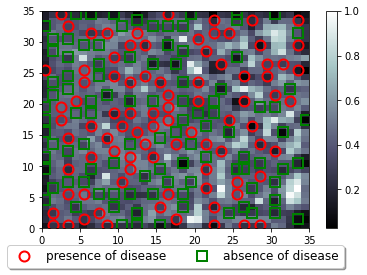

In [65]:
draw_distance_plot(som_35x35)
draw_classes(som_35x35, X_train, y_train)
draw_legend_for_Umatrix((0.5, -0.05))


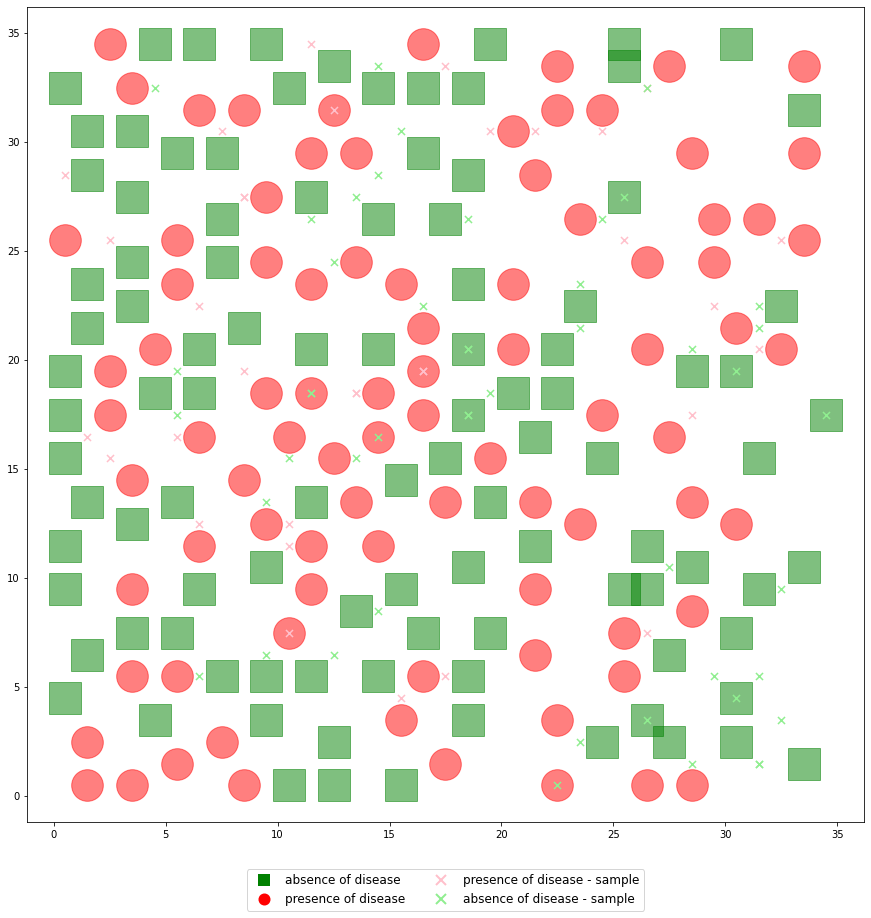

In [66]:
plt.figure(figsize=(15,15))
draw_clusters(som_35x35, X_train)
draw_samples(som_35x35, X_test, y_test, marker='x', color1='lightgreen', color2='pink', offset=0)
draw_legend_for_sample_distribution((0.5, -0.05))

Tutaj widzimy jak nasza sieć się przuczyła, każda próbka danych treningowych została przydzielona do innego neuronu

#### Outliers

Aby polepszyć SOM, można pozbyć się danych które nie są ważne dla modelu. Dlatego sprawdzę macierz korelacji dla naszych danych i poszukam mniej ważnych kolumn.

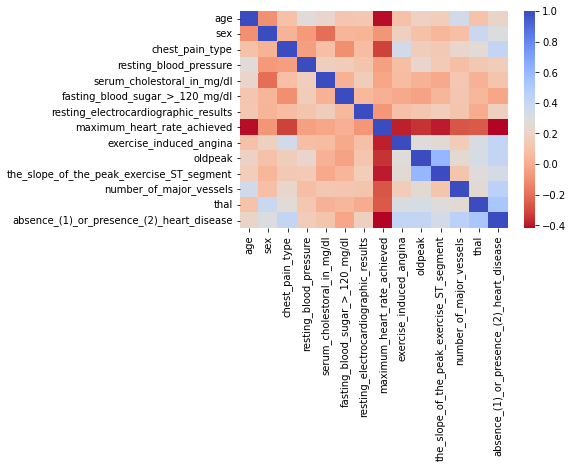

In [67]:
sns.heatmap(heart_data.corr(),cmap='coolwarm_r')
plt.show()

Ta heat mapa wyświetla nam jak bardzo skorelowane są ze sobą dane kolumny. Dla wartości 1 mamy najbardziej skorelowane dane, jest to przekątna ponieważ korelacja między tą samą kolumną jest idealna. Dla wartości -1 również mamy silną korelację, tylko w przeciwną stronę. Wartości bliskie zeru oznaczają słabą korelację.

Widać, że w tych danych jest kilka kolumn które są słabo skorelowane z resztą np.: 'sex', 'serum_cholestoral_in_mg/dl', 'resting_electrocardiographic_results', 'fasting_blood_sugar_>_120_mg/dl', 'resting_blood_pressure'

W kolejnych krokach sprawdzę czy usunięcie tych kolumn wpłynie na polepszenie sieci.

In [68]:
dataset.columns

Index(['resting_blood_pressure', 'serum_cholestoral_in_mg/dl',
       'maximum_heart_rate_achieved', 'oldpeak', 'sex_0.0', 'sex_1.0', 'age_0',
       'age_1', 'age_2', 'chest_pain_type_1.0', 'chest_pain_type_2.0',
       'chest_pain_type_3.0', 'chest_pain_type_4.0',
       'fasting_blood_sugar_>_120_mg/dl_0.0',
       'fasting_blood_sugar_>_120_mg/dl_1.0',
       'resting_electrocardiographic_results_0.0',
       'resting_electrocardiographic_results_1.0',
       'resting_electrocardiographic_results_2.0',
       'exercise_induced_angina_0.0', 'exercise_induced_angina_1.0',
       'the_slope_of_the_peak_exercise_ST_segment_1.0',
       'the_slope_of_the_peak_exercise_ST_segment_2.0',
       'the_slope_of_the_peak_exercise_ST_segment_3.0',
       'number_of_major_vessels_0.0', 'number_of_major_vessels_1.0',
       'number_of_major_vessels_2.0', 'number_of_major_vessels_3.0',
       'thal_3.0', 'thal_6.0', 'thal_7.0'],
      dtype='object')

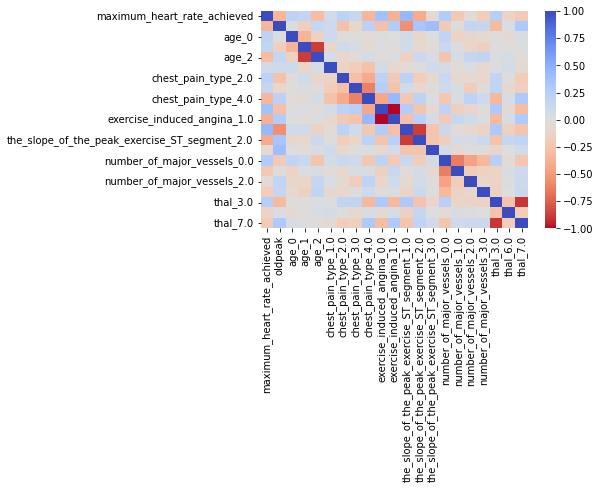

In [69]:
# removing outliers
data_rm = dataset.drop(['sex_0.0','sex_1.0', 'serum_cholestoral_in_mg/dl','resting_electrocardiographic_results_0.0','resting_electrocardiographic_results_1.0','resting_electrocardiographic_results_2.0',  'fasting_blood_sugar_>_120_mg/dl_0.0','fasting_blood_sugar_>_120_mg/dl_1.0', 'resting_blood_pressure'], axis='columns')

sns.heatmap(data_rm.corr(),cmap='coolwarm_r')
X_rm = data_rm.values #independent variables (features)
y_rm = y #dependent variables (output of process)

X_train_rm,X_test_rm,y_train_rm,y_test_rm = train_test_split(X_rm,y_rm,test_size=test_size,random_state=0) 


Tutaj widzimy macierz korelacji już po usunięciu kolumn:
'sex', 'serum_cholestoral_in_mg/dl', 'resting_electrocardiographic_results', 'fasting_blood_sugar_>_120_mg/dl', 'resting_blood_pressure'.

Stworzę teraz model SOM dla okrojonych danych, z uprzednio dobranymi parametrami.

In [70]:

som_grid_rows = int(np.sqrt(5*np.sqrt(dataset.shape[0])))
som_grid_columns = som_grid_rows
iterations = 5000
sigma = 2
learning_rate = 0.7
neighborhood_function = "triangle"
topology = 'rectangular'
activation_distance = 'euclidean'

Skaluje dane w zakresie (0,1)

In [71]:
X_train_rm = scale_in_range(X_train_rm, 1)
X_test_rm = scale_in_range(X_test_rm, 1)

In [72]:
som_rm=MiniSom(x=som_grid_rows, y=som_grid_columns, input_len=X_rm.shape[1], sigma = sigma, learning_rate= learning_rate, neighborhood_function=neighborhood_function, topology=topology,activation_distance=activation_distance)
som_rm.random_weights_init(X_train_rm)

In [73]:
print("\n --- For data without outliers ---")
som_rm.train(data=X_train_rm, num_iteration=iterations, random_order= False, verbose=True)
print(" topographic error: ", som_rm.topographic_error(X_train_rm))

print("\n --- For all data ---")
print(" quantization error: ", som_triangle.quantization_error(X_train))
print(" topographic error: ", som_triangle.topographic_error(X_train))


 --- For data without outliers ---
 [ 5000 / 5000 ] 100% - 0:00:00 left 
 quantization error: 0.35518850728855034
 topographic error:  0.291005291005291

 --- For all data ---
 quantization error:  0.6295862869665969
 topographic error:  0.3544973544973545


Widać poprawę, ponieważ błędy zmalały względem wyników SOM dla pełnych danych.

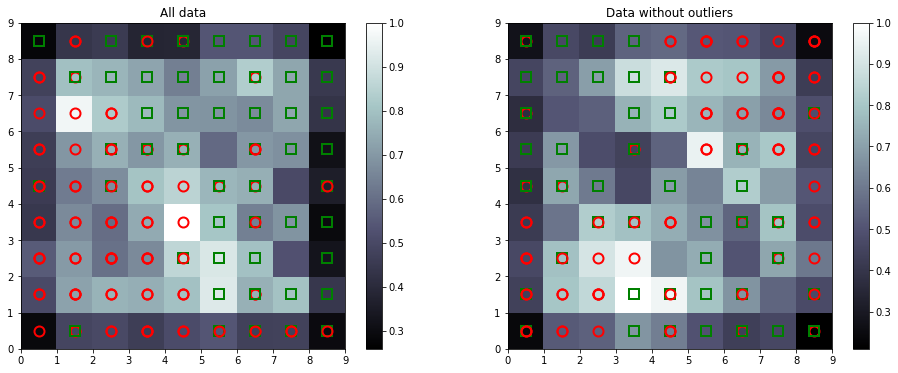

In [74]:
plt.figure(figsize=(16,6))

plt.subplot(1, 2, 1)
plt.title("All data")
draw_distance_plot(som_triangle)
draw_classes(som_triangle, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Data without outliers")
draw_distance_plot(som_rm)
draw_classes(som_rm, X_train_rm, y_train_rm)

Nadal nie mamy wyraźnego rozgraniczenia klastrów. Jednak dla okrojonych danych niektóre miejsca mapy odległości stały się ciemniejsze, zatem klastry się powiększyły.

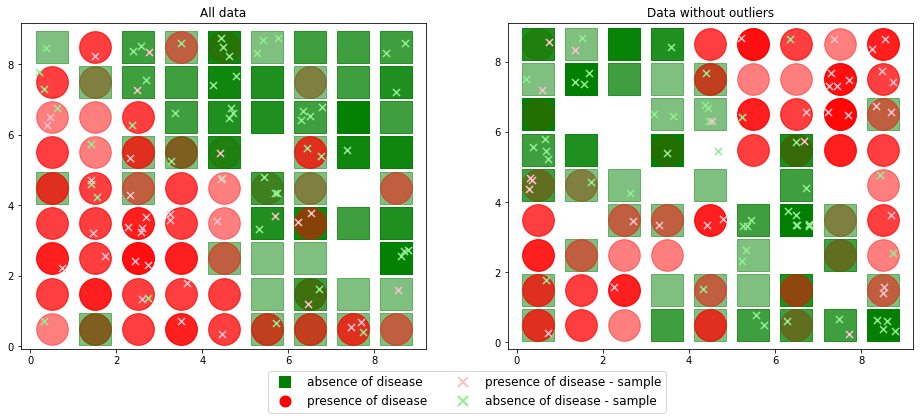

In [75]:

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.title("All data")
draw_clusters(som_triangle, X_train)
draw_samples(som_triangle, X_test, y_test, marker='x', color1='lightgreen', color2='pink', offset=0.3)

plt.subplot(1,2,2)
plt.title("Data without outliers")
draw_clusters(som_rm, X_train_rm)
draw_samples(som_rm, X_test_rm, y_test_rm, marker='x', color1='lightgreen', color2='pink', offset=0.3)

draw_legend_for_sample_distribution((-0.1, -0.05))


Nie zawsze, ale przy niektóych uruchomieniach programu próbki, dla danych okrojonych, w mniejszym stopniu trafiają w nieoznaczone neurony (czyli takie które przy treningu nigdy nie wygrały).

In [76]:

class_assignments = som_rm.labels_map(X_train_rm, y_train_rm)
print("Data without outliers:")
print(classification_report(y_test_rm, classify(som_rm, X_test_rm, class_assignments), target_names=["absence of disease", "presence of disease"]))

report_rm = classification_report(y_test_rm, classify(som_rm, X_test_rm, class_assignments), target_names=["absence of disease", "presence of disease"], output_dict=True)
print("For all data:")
print("Accuracy: ",report_triangle["accuracy"])
print("absence of disease - F1 score: ",report_triangle["absence of disease"]["f1-score"])
print("presence of disease - F1 score: ",report_triangle["presence of disease"]["f1-score"])


Data without outliers:
                     precision    recall  f1-score   support

 absence of disease       0.73      0.85      0.79        48
presence of disease       0.72      0.55      0.62        33

           accuracy                           0.73        81
          macro avg       0.73      0.70      0.70        81
       weighted avg       0.73      0.73      0.72        81

For all data:
Accuracy:  0.7037037037037037
absence of disease - F1 score:  0.7272727272727272
presence of disease - F1 score:  0.6756756756756757


Pozbycie się tych kolumn polepszyło model. 

#### Inne skalowanie
Na początku opisując skalowanie pisałam, że przeskalowanie wszystkich danych do jednego zakresuu spowoduje traktowanie ich jako równie ważnych przez SOM.
Jednak jeśli jakiś parametr jest ważniejszy dla trendu można go przeskalować aby był większy od pozostałych, a wtedy zostanie uznany za ważniejszy.

Patrząc na mape korelacji, myślę, że najlepszym kandydatem do sprawdzenia tej teorii będzie kolumna thal, jest ona najbardziej skorelowana ze wszystkich z wynikiem. 

In [77]:
thal = pd.DataFrame({'thal_3.0': data_rm['thal_3.0'], 'thal_6.0': data_rm['thal_6.0'], 'thal_7.0': data_rm['thal_7.0']})

data_without_thal = data_rm.drop(['thal_3.0','thal_6.0','thal_7.0'], axis='columns')


X_thal = data_without_thal.values #independent variables (features)
y_thal = y #dependent variables (output of process)

X_thal = scale_in_range(X_thal,1)
thal = scale_in_range(thal, 3)

X_thal = np.c_[X_thal, thal]

X_train_thal,X_test_thal,y_train_thal,y_test_thal = train_test_split(X_thal,y_thal,test_size=test_size,random_state=0) 


Kolumnę thal skaluje aby byla w przedziale 0-3, pozostałe parametry są w przedziale 0-1.

In [78]:
som_grid_rows = int(np.sqrt(5*np.sqrt(dataset.shape[0])))
som_grid_columns = som_grid_rows
iterations = 5000
sigma = 2
learning_rate = 0.7
neighborhood_function = "triangle"
topology = 'rectangular'
activation_distance = 'euclidean'

In [79]:
som_thal=MiniSom(x=som_grid_rows, y=som_grid_columns, input_len=X_thal.shape[1], sigma = sigma, learning_rate= learning_rate, neighborhood_function=neighborhood_function, topology=topology,activation_distance=activation_distance)
som_thal.random_weights_init(X_train_thal)

In [80]:
print("\n --- For all data ---")
som_triangle.train(data=X_train, num_iteration=iterations, random_order= False, verbose=True)
print(" topographic_error: ", som_triangle.topographic_error(X_train))


print("\n --- For data without outliers ---")
som_rm.train(data=X_train_rm, num_iteration=iterations, random_order= False, verbose=True)
print(" topographic_error: ", som_rm.topographic_error(X_train_rm))

print("\n --- For data with different scaling ---")
som_thal.train(data=X_train_thal, num_iteration=iterations, random_order= False, verbose=True)
print(" topographic_error: ", som_thal.topographic_error(X_train_thal))




 --- For all data ---
 [ 5000 / 5000 ] 100% - 0:00:00 left 
 quantization error: 0.6210686897731869
 topographic_error:  0.4021164021164021

 --- For data without outliers ---
 [ 5000 / 5000 ] 100% - 0:00:00 left 
 quantization error: 0.3701457207496609
 topographic_error:  0.25925925925925924

 --- For data with different scaling ---
 [ 5000 / 5000 ] 100% - 0:00:00 left 
 quantization error: 0.4202930572506186
 topographic_error:  0.2857142857142857


Dla okrojonych danych błąd zmalał, za to już skalowanie nie koniecznie polepsza błąd względem danych poprostu przeczyszczonych.



In [81]:

print("For all data:")
print("Accuracy: ",report_triangle["accuracy"])
print("absence of disease - F1 score: ",report_triangle["absence of disease"]["f1-score"])
print("presence of disease - F1 score: ",report_triangle["presence of disease"]["f1-score"])

print("\nFor data without outliers:")
print("Accuracy: ",report_rm["accuracy"])
print("absence of disease - F1 score: ",report_rm["absence of disease"]["f1-score"])
print("presence of disease - F1 score: ",report_rm["presence of disease"]["f1-score"])

print("\nFor data with different scaling:")
class_assignments = som_thal.labels_map(X_train_thal, y_train_thal)
report = classification_report(y_test_thal, classify(som_thal, X_test_thal, class_assignments), target_names=["absence of disease", "presence of disease"])
print(report)
report_thal = classification_report(y_test_thal, classify(som_thal, X_test_thal, class_assignments), target_names=["absence of disease", "presence of disease"], output_dict=True)


For all data:
Accuracy:  0.7037037037037037
absence of disease - F1 score:  0.7272727272727272
presence of disease - F1 score:  0.6756756756756757

For data without outliers:
Accuracy:  0.7283950617283951
absence of disease - F1 score:  0.7884615384615384
presence of disease - F1 score:  0.6206896551724138

For data with different scaling:
                     precision    recall  f1-score   support

 absence of disease       0.85      0.83      0.84        48
presence of disease       0.76      0.79      0.78        33

           accuracy                           0.81        81
          macro avg       0.81      0.81      0.81        81
       weighted avg       0.82      0.81      0.82        81





F1 sore oraz accuracy pogorszyło się po skalowaniu względem okrojonych danych.

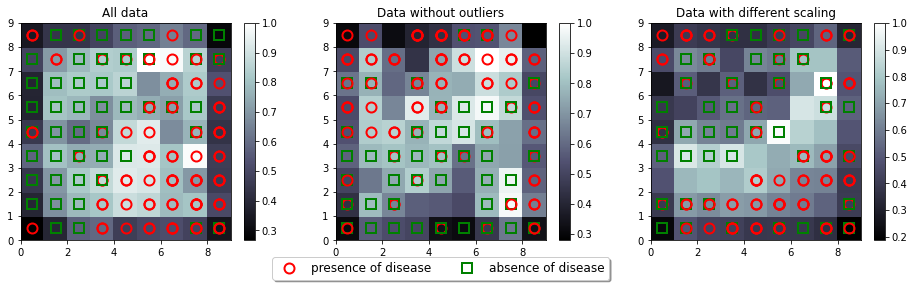

In [82]:
plt.figure(figsize=(16,4))

plt.subplot(1, 3, 1)
plt.title("All data")
draw_distance_plot(som_triangle)
draw_classes(som_triangle, X_train, y_train)

plt.subplot(1, 3, 2)
plt.title("Data without outliers")
draw_distance_plot(som_rm)
draw_classes(som_rm, X_train_rm, y_train_rm)

plt.subplot(1, 3, 3)
plt.title("Data with different scaling")
draw_distance_plot(som_thal)
draw_classes(som_thal, X_train_thal, y_train_thal)

draw_legend_for_Umatrix((-1, -0.05))


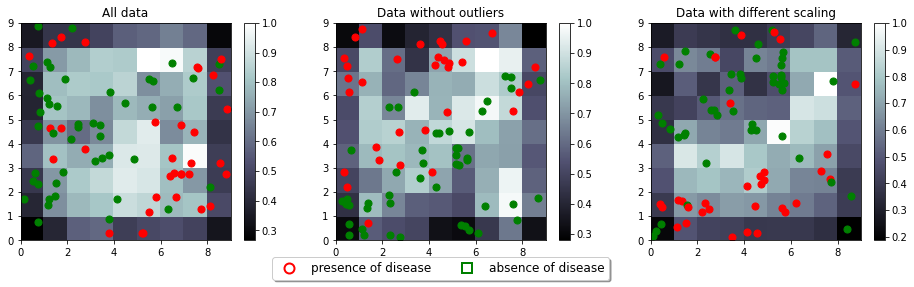

In [83]:
plt.figure(figsize=(16,4))

plt.subplot(1, 3, 1)
plt.title("All data")
draw_distance_plot(som_triangle)
draw_samples(som_triangle, X_test, y_test, marker='o', color1='green', color2='red', offset=0.4)

plt.subplot(1, 3, 2)
plt.title("Data without outliers")
draw_distance_plot(som_rm)
draw_samples(som_rm, X_test_rm, y_test_rm, marker='o', color1='green', color2='red', offset=0.4)

plt.subplot(1, 3, 3)
plt.title("Data with different scaling")
draw_distance_plot(som_thal)
draw_samples(som_thal, X_test_thal, y_test_thal, marker='o', color1='green', color2='red', offset=0.4)

draw_legend_for_Umatrix((-1, -0.05))

Po przeskalowaniu wartości thal na większą nasza distance mapa zaczyna nabierać kształtu. Wydzielają się dwa wyraźniejsze klastry, widać jasną linie oddzielającą, jednak klasy w tych klastrach są nadal zmieszane.

In [84]:
print("All data - Accuracy: ",report_triangle["accuracy"])
print("Data without outliers - Accuracy: ",report_rm["accuracy"])
print("Data with different scaling - Accuracy: ",report_thal["accuracy"])



All data - Accuracy:  0.7037037037037037
Data without outliers - Accuracy:  0.7283950617283951
Data with different scaling - Accuracy:  0.8148148148148148


### Podsumowanie
Udało się uzyskać wynik accuracy w okolicach 80% po wyrzuceniu mało skorelowanych danych.
Self organizing map jest siecią która generalnie nie nadaje się raczej do rozwiązywanie problemów 2 klasowych. Co dobrze ilustruje poniższy obrazek. 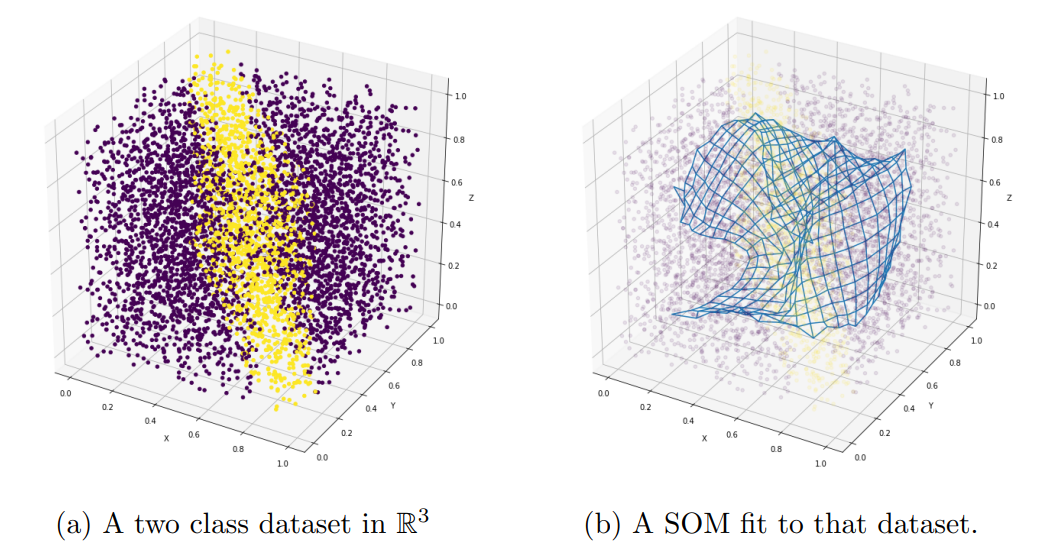

wykres pochodzi ze strony: https://www.osti.gov/biblio/1566795/

Widzimy, że poroblemy 2 klasowe są trudne dla sieci SOM. Idelna ilość użytych neuronów do stworzenia siatki powinna być równa ilości klastrów na które chcemy podzielić nasze dane, przy 2 klastrach jest raczej niemożliwe aby ta siatka działała w poprawny sposób.